# 0. Setup

In [1]:
from dotenv import load_dotenv
import os

# Load environment variables
result = load_dotenv(dotenv_path='../.env')
print(f"Environment loaded: {result}")
print(f"OPENAI_API_KEY exists: {bool(os.getenv('OPENAI_API_KEY'))}")
print(f"OPENAI_API_KEY length: {len(os.getenv('OPENAI_API_KEY', ''))}")

Environment loaded: True
OPENAI_API_KEY exists: True
OPENAI_API_KEY length: 164


In [2]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [3]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Chains

In [5]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs);

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

*** Use a list of messages as the application state: use MessagesState

* User input as a HumanMessage;
* Vector store query as an AIMessage with tool calls;
* Retrieved documents as a ToolMessage;
* Final response as a AIMessage.

In [7]:
# MessagesState defines a dictionary of messages (Human, AI or System --Messages)
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

*** Replace "query analysis" step with a "retriever" tool

In [8]:
from langchain_core.messages import SystemMessage
from langgraph.graph import MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    # get all messages except tool messages
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [9]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

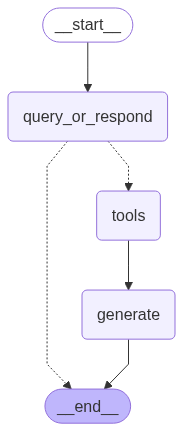

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [12]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_AIsoHWquXuXmWvsRZA90WfHM)
 Call ID: call_AIsoHWquXuXmWvsRZA90WfHM
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to des

### Stateful Management of Chat History

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [14]:
# When using the stream methods, choose one or more streaming mode to control the type of output that is streamed.
# The available streaming modes are:
#   "values": Emit all values of the state for each step.
#   "updates": Emit only the node name(s) and updates that were returned by the node(s) after each step.
#   "debug": Emit debug events for each step.
#   "messages": Emit LLM messages token-by-token.
#   "custom": Emit custom output written using LangGraph's StreamWriter.

input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values", # emit all value of the state
    config=config, # set the thread ID to support statefull chat
):
    step["messages"][-1].pretty_print() # print the lasst message of each step

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_9oQ44pMHfKju9Z1wMRlibMZn)
 Call ID: call_9oQ44pMHfKju9Z1wMRlibMZn
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to des

In [15]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_EpX8kOj6SgYTYcx5aaXaaa54)
 Call ID: call_EpX8kOj6SgYTYcx5aaXaaa54
  Args:
    query: common ways of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as

## Agents

In [16]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

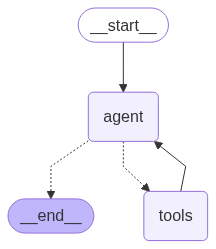

In [17]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [18]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_p76rhywCz7kyRJSwUVIXjw1I)
 Call ID: call_p76rhywCz7kyRJSwUVIXjw1I
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon pla